<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

В проекте компании «Чётенькое такси» необходимо посмтроить прогноз количества заказов такси на следующий час для привлечения водителей в зоны аэропортов в пиковые часы нагрузок.

In [1]:
%pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error
import datetime as dt
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from catboost import  CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data_copy = pd.read_csv('/datasets/taxi.csv')

In [7]:

data.sort_index(inplace=True)
data = data.resample('h').sum()


## Анализ

проанализируем данные, посмотрим сезонность, тренд

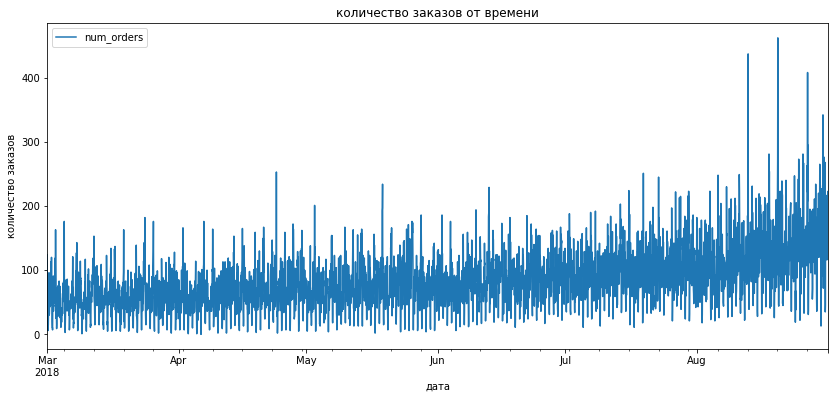

In [8]:
data.plot(figsize=(14, 6))
plt.xlabel('дата')
plt.ylabel('количество заказов')
plt.title('количество заказов от времени');


In [9]:
decomposed = seasonal_decompose(data)

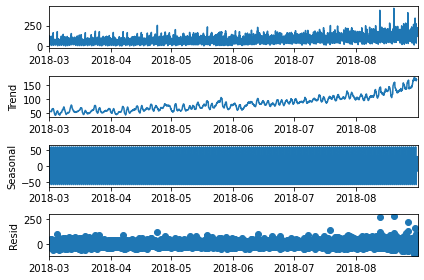

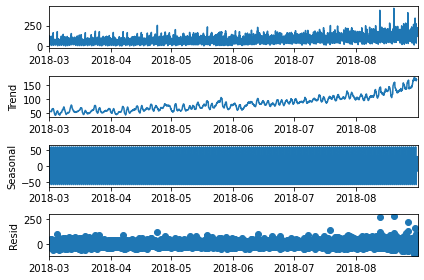

In [10]:
decomposed.plot()

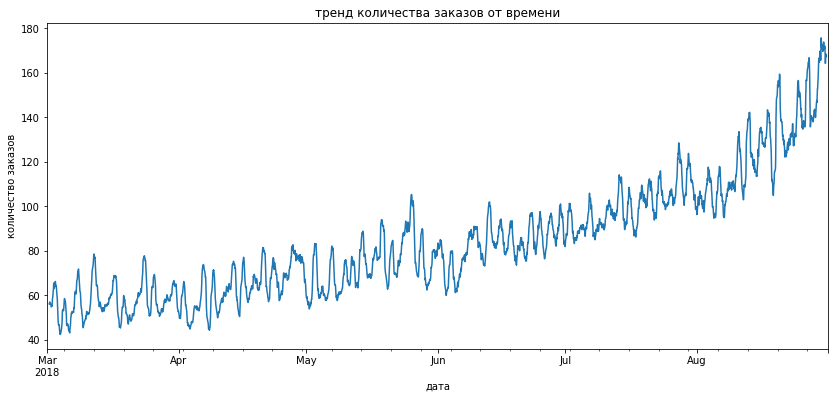

In [11]:
decomposed.trend.plot(figsize=(14, 6))
plt.xlabel('дата')
plt.ylabel('количество заказов')
plt.title('тренд количества заказов от времени');

In [12]:
#decomposed.seasonal.plot(figsize=(14, 6))
#plt.xlabel('дата')
#plt.ylabel('сезонность ')
#plt.title('сезонность количества заказов');

рассмотрим сезонность, тренд за июнь

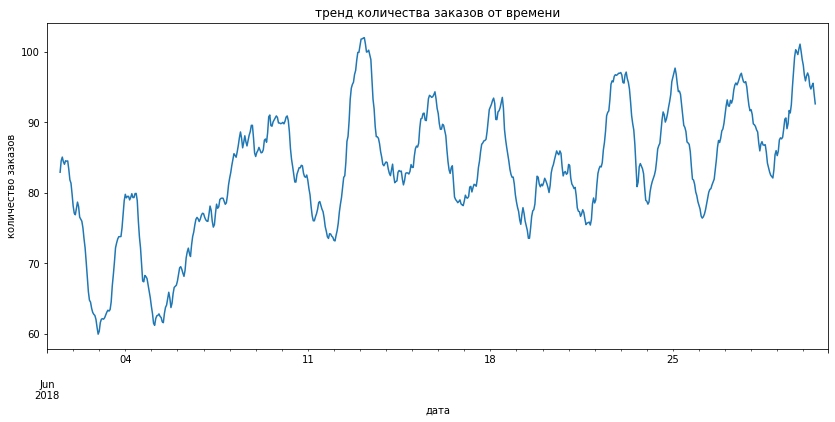

In [13]:
seasonal_decompose(data['2018-06-01':'2018-06-30']).trend.plot(figsize=(14, 6))
plt.xlabel('дата')
plt.ylabel('количество заказов')
plt.title('тренд количества заказов от времени');

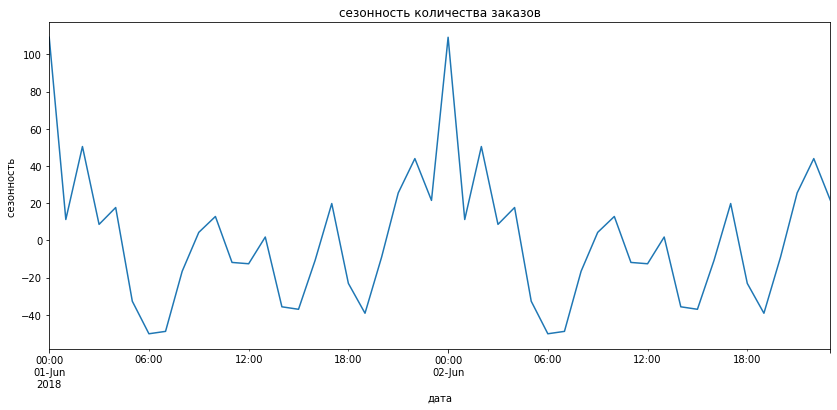

In [14]:
seasonal_decompose(data['2018-06-01':'2018-06-02']).seasonal.plot(figsize=(14, 6))
plt.xlabel('дата')
plt.ylabel('сезонность ')
plt.title('сезонность количества заказов');

из графикоф видно, что тренд растет, количество заказов в утренее время низкое, а в полночь-высокое

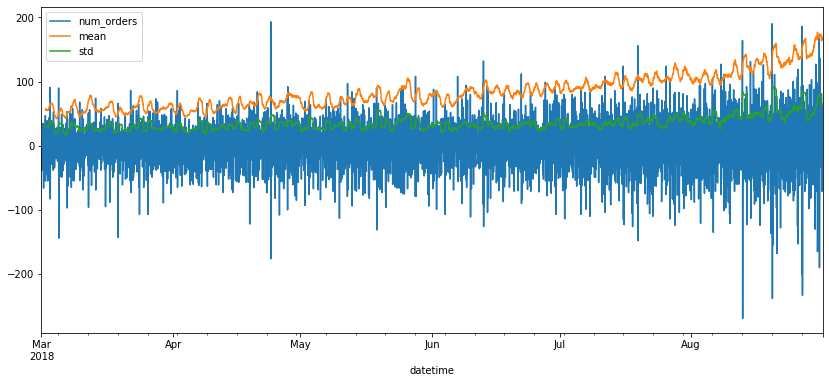

In [15]:
taxi_shift = data - data.shift()
taxi_shift['mean'] = data['num_orders'].rolling(24).mean()
taxi_shift['std'] = data['num_orders'].rolling(24).std()
taxi_shift.plot(figsize=(14, 6));


Тренд  возрастающий, то есть кол-во заказов и пользователей растет. ярко выраженная сезонность в начале и середине года

In [16]:
data_copy.columns

Index(['datetime', 'num_orders'], dtype='object')

In [17]:
data_copy['datetime'] = pd.to_datetime(data_copy['datetime'])
data_copy = data_copy.set_index('datetime')
data_copy = data_copy.resample('h').sum()
data_copy = data_copy.reset_index()

In [18]:
data_copy = data_copy.rename(columns={'datetime': 'ds', 'num_orders': 'y'})

In [19]:
data_copy

,ds,y
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43
...,...,...
4411,2018-08-31 19:00:00,136
4412,2018-08-31 20:00:00,154
4413,2018-08-31 21:00:00,159
4414,2018-08-31 22:00:00,223


In [20]:
# Создадим признаки для обучения модели
max_lag = 24
rolling_mean_size = 48
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [21]:
data_copy1 = data.copy()

make_features(data,'num_orders', max_lag, rolling_mean_size)

train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=12345)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [22]:
features_train

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,3,5,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,59.791667
2018-03-03 01:00:00,3,5,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,60.604167
2018-03-03 02:00:00,3,5,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,61.083333
2018-03-03 03:00:00,3,5,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,60.125000
2018-03-03 04:00:00,3,5,64.0,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,60.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,13,0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,...,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,108.0,119.416667
2018-08-13 10:00:00,13,0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,...,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,119.770833
2018-08-13 11:00:00,13,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,120.104167


## Обучение

обучим модель из библиотеки prophet

In [24]:
data_copy = data_copy.rename(columns={'datetime': 'ds', 'num_orders': 'y'})

In [25]:
train_prophet, test_prophet = train_test_split(data_copy, shuffle=False, test_size=0.1, random_state=12345)

In [26]:
model = Prophet()

In [27]:
model.fit(train_prophet)

13:34:40 - cmdstanpy - INFO - Chain [1] start processing
13:34:41 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
future = model.make_future_dataframe(periods=416, freq='H')

In [29]:
forecast = model.predict(future)

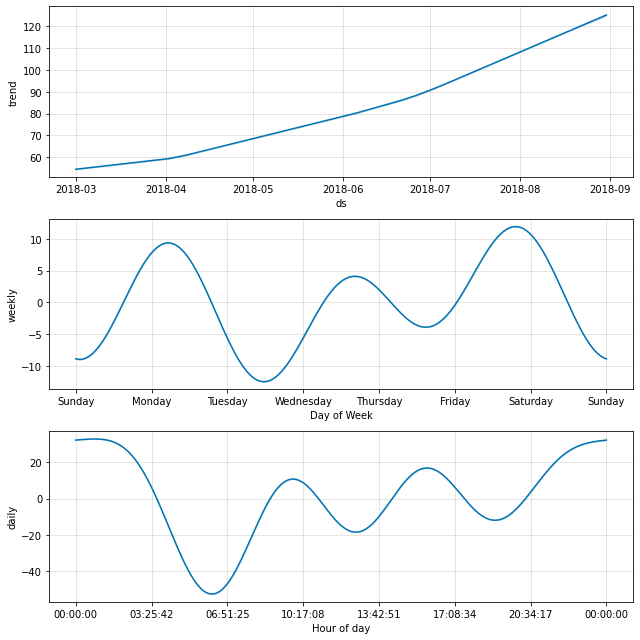

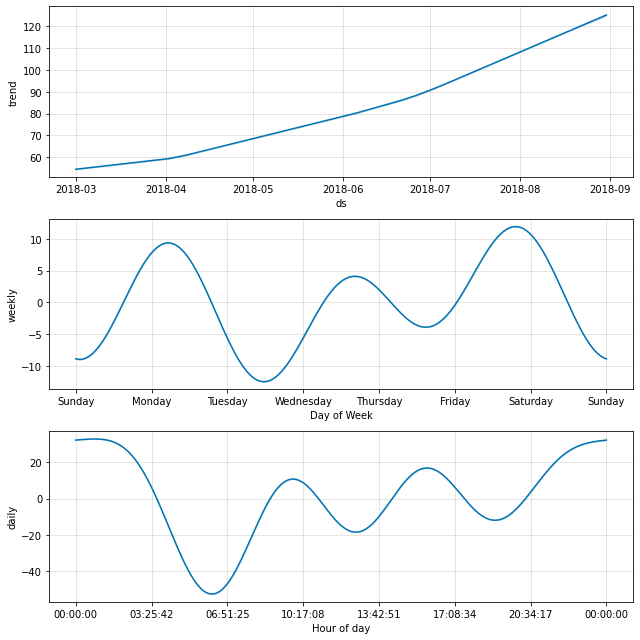

In [30]:
model.plot_components(forecast)

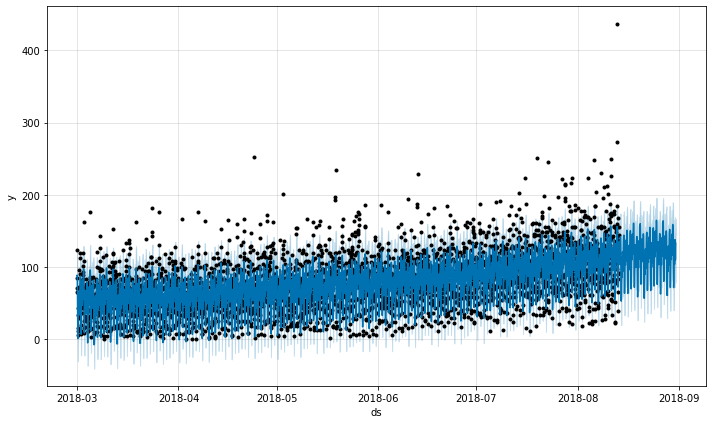

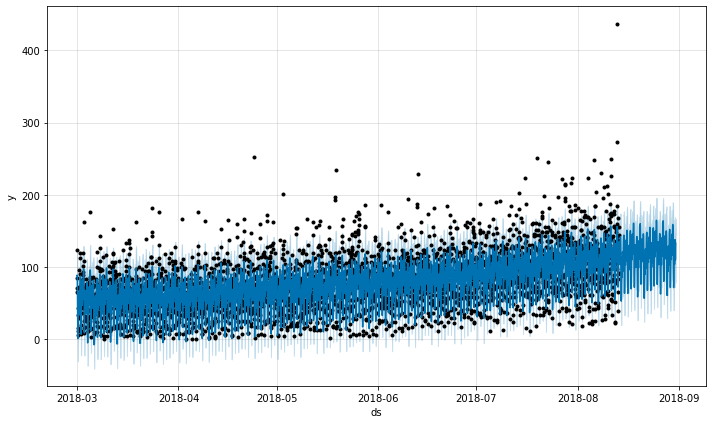

In [31]:
model.plot(forecast)

In [32]:
print('prophet rmse :',(mean_squared_error(train_prophet.y, forecast.loc[:3973, 'yhat'].values)**0.5))


prophet rmse : 24.588766605808466


model Linear Regression

In [37]:
tscv = TimeSeriesSplit(n_splits=8)
regressor = LinearRegression()
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 27.146562377544374


model DecisionTreeRegressor

In [38]:
%%time
tscv = TimeSeriesSplit(n_splits=8)
regressor = DecisionTreeRegressor()
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of DecisionTreeRegressor =', cv_RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of DecisionTreeRegressor = 35.30116577460115
CPU times: user 357 ms, sys: 0 ns, total: 357 ms
Wall time: 380 ms


In [39]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
#С помощию функции make_scorer создаю метрику RMSE
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [40]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
forest = RandomForestRegressor()
#Определяю словарь с набором параметров
forest_parametrs = { 'n_estimators': range(5, 30, 50),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }

#Применяю GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=my_cv)
forest_grid.fit(features_train, target_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fe7a068d4a0>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 30, 50)},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [41]:
forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train, target_train) * (-1)
print(forest_params)
print(forest_score)

{'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 5}
15.898635272188645


проведем обучение модели CatBoost

In [42]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5],
                'random_state':[12345],
                'verbose':[False]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")

print(clf.best_params_)

print("Grid scores on development set:")

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

Best parameters set found on development set:
{'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
Grid scores on development set:
24.089212 for {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
24.916871 for {'learning_rate': 0.2, 'random_state': 12345, 'verbose': False}
25.268045 for {'learning_rate': 0.3, 'random_state': 12345, 'verbose': False}
26.121490 for {'learning_rate': 0.4, 'random_state': 12345, 'verbose': False}
26.454871 for {'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}

CPU times: user 2min 32s, sys: 3.26 s, total: 2min 35s
Wall time: 2min 58s


In [43]:
cv_RMSE_CBR_ordinal

24.08921191772061

проведем изучение модели LGBM Regressor

In [44]:
regressor = LGBMRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.3, 0.4, 0.6],
                'random_state':[12345]}]
print('# Tuning hyper-parameters for root_mean_squared_error')
print('---------------')
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error
---------------
Best parameters set found on development set:

{'learning_rate': 0.1, 'random_state': 12345}

Grid scores on development set:

24.871622 for {'learning_rate': 0.1, 'random_state': 12345}
26.044211 for {'learning_rate': 0.3, 'random_state': 12345}
26.789192 for {'learning_rate': 0.4, 'random_state': 12345}
28.204442 for {'learning_rate': 0.6, 'random_state': 12345}



в модели RandomForestRegressor показатель rmse меньше, значит модель точнее. применем ее на тестовой выборке 

## Тестирование

In [45]:
%%time
#Обучаю модель на оптимальных гиперпараметрах
forest_model = RandomForestRegressor(random_state=42,
                                     max_depth=forest_params['max_depth'],
                                     min_samples_leaf = forest_params['min_samples_leaf'],
                                     min_samples_split = forest_params['min_samples_split'],
                                     n_estimators = forest_params['n_estimators'])

forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)

#Определяю метрику RMSE
forest_RMSE = round(RMSE(target_test, forest_model_predictions), 3)
print('RMSE модели Случайного леса:', forest_RMSE)

RMSE модели Случайного леса: 44.365
CPU times: user 209 ms, sys: 62 µs, total: 209 ms
Wall time: 288 ms


вывод: таким образом, были проанализированы данные при помощи графикоф, построены модели(регрессии дерева решений и с помощью библиотеки prophet).Модель с помощью библиотеки prophet показала лучший результат на тренировачной выборке, и была протестирована на тестовой